C:\Users\khan1\Anaconda3\lib\site-packages\sklearn\neighbors\lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


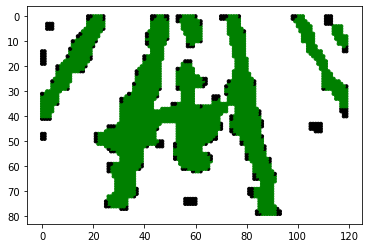

In [12]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy.polynomial.polynomial as poly
import time
import hdbscan
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor


#function to do color based segmentation
def combined (img):
    #b, g, r = cv2.split(img)
    b = img[:, :, 0]
    g = img[:, :, 1]
    r = img[:, :, 2]
    #r_max = g_max = b_max = 255
    r_max = np.amax(r)
    g_max = np.amax(g)
    b_max = np.amax(b)
    #print (r)
    #cv2.imshow("red chaneel",b)

    red_norm = r/r_max
    green_norm = g/g_max
    blue_norm = b/b_max

   # print(red_norm.shape)

    norm = red_norm + blue_norm + green_norm


    small_num = 0.0001
    r = red_norm/(norm+small_num)
    g = green_norm/(norm+small_num)
    b = blue_norm/(norm+small_num)

    #print('normalized r g b values: %d %d %d' %(r, g, b))

    ExG = 2*g - r - b #excess green

    #ExGR = ExG -1.4*r - g #excess green minus red

    #CIVE = 0.441*r - 0.811*g + 0.385*b + 18.78745 #color index of vegetation extraction

    #redistribute the weights without VEG
    #w_ExG = 0.28
    #w_ExGR = 0.34
    #w_CIVE = 0.38

    #combined = w_ExG * ExG + w_ExGR * ExGR + w_CIVE * CIVE

    return ExG



img = cv2.imread(r'C:\Users\khan1\jupyter_test_code\CRBD\Images\crop_row_014.jpg')

height = img.shape[0]
width = img.shape[1]

#crop ROI
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3 + 20):int(120+(width / 3))] #wsmall
crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3):int(120+(width / 3))] #small
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3 - 20):int(120+(width / 3))] #big
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3 - 40):int(120+(width / 3))] #vbig
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3 - 20):int(120+(width / 3 - 20))] #wsmall

img = crop_img

max_value = np.max(combined(img))
min_value = np.min(combined(img))

###mapped combined image value (which is mostly negative) to 0-255
new_min = 0
new_max = 255
old_range = max_value - min_value
new_range = new_max - new_min
lin_map = (((combined(img).astype(np.float64) - min_value) * new_range) / old_range) + new_min
image_map = lin_map.astype(np.uint8)
###OTSU threshold
thresh_val,thresh_img = cv2.threshold(image_map,0,255,cv2.THRESH_OTSU)

###Morphology Opening-Closing to delete small weed segments
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh_img, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

#plt.imshow(closing, cmap='gray')
### all the white pixel coordinates in segemented image after noise clean

indices = np.where(closing == [255])
coordinates = list(zip(indices[0], indices[1]))

data = np.array(coordinates)
y_x_data = np.flip(data)

Ydata = y_x_data.T[0] #we plot this on x-axis
Xdata = y_x_data.T[1] #we plot this on y_axis

#print(Xdata.shape)

#### Test LOF ###
ground_truth = np.ones(len(y_x_data), dtype=int)

#clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
clf = LocalOutlierFactor()
y_pred = clf.fit_predict(y_x_data)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

#print(y_pred)

colors = np.array(['black', 'green'])
plt.scatter(y_x_data[:, 0], y_x_data[:, 1], s=10, color=colors[(y_pred + 1) // 2])
plt.gca().invert_yaxis()